In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import V1Circuit
from dsn.util.dsn_util import get_savedir, get_ME_model, load_DSNs, \
                              get_system_from_template, get_arch_from_template
from dsn.util.plot_util import assess_constraints_mix, plot_opt, dsn_pairplots, \
                               pairplot, lin_reg_plot
from tf_util.stat_util import approx_equal
import matplotlib.backends.backend_pdf
from sklearn import linear_model
from dsn.util.plot_util import PCA
from tf_util.tf_util import load_dgm
from tf_util.tf_util import get_dgm_hessian, dgm_hessian


import os

os.chdir('../../')

In [2]:
EPS = 1e-16

# normalizing flow layer architecture
# number of layers
K = 1
repeats = 1
flow_type = "RealNVP"

#dirstr = 'V1Circuit_0-20'
dirstr = 'V1Circuit'

lr_order = -3

sysname = 'V1Circuit'
behavior_type = "ISN_coeff"


In [63]:
# multivariate normal initialization variance
c_init_ords = np.array([5])
start_rs = 1
num_rs = 4
upls = [15]
sigma_inits = [5.0]
random_seeds = np.arange(start_rs, num_rs+start_rs)

In [64]:
best_models = []
ME_its = []

alpha=0.05
frac_samps=0.5

conv_dict = {
    'alpha':alpha,
    'frac_samples':frac_samps,
}

systems = []
np.random.seed(0)

param_dict = {'behavior_type':behavior_type}

system = get_system_from_template("V1Circuit", param_dict)

max_ME = None
for upl in upls:
    for sigma_init in sigma_inits:
        real_nvp_arch = {
                     'num_masks':8,
                     'nlayers':2,
                     'upl':upl,
                    }

        arch_params = {
                   'D':system.D,
                   'repeats':repeats,
                   'nlayers':2,
                   'upl':upl,
                   'sigma_init':sigma_init,
                  }
        param_dict.update(arch_params)
        arch_dict = get_arch_from_template(system, param_dict)

        _best_model, _max_ME, _ME_it, first_it = get_ME_model(system, arch_dict, c_init_ords, 
                                                           random_seeds, dirstr, 
                                                           conv_dict)
        if (max_ME is None):
            print('None update')
            max_ME = _max_ME
            best_model = _best_model
            ME_it = _ME_it
        elif (_max_ME is not None and _max_ME > max_ME):
            print('update')
            max_ME = _max_ME
            best_model = _best_model
            ME_it = _ME_it



None
15 5.0 models/V1Circuit/V1Circuit_D=8_ISN_0.00E+00_5.00E-01_flow=1R_8M_2L_15U_M_A_sigma=5.00_c=5_rs=1/ 27 -51.83418939524998
None update


In [65]:
print(best_model, ME_it)

models/V1Circuit/V1Circuit_D=8_ISN_0.00E+00_5.00E-01_flow=1R_8M_2L_15U_M_A_sigma=5.00_c=5_rs=1/ 27


0
dist (1000, 8)


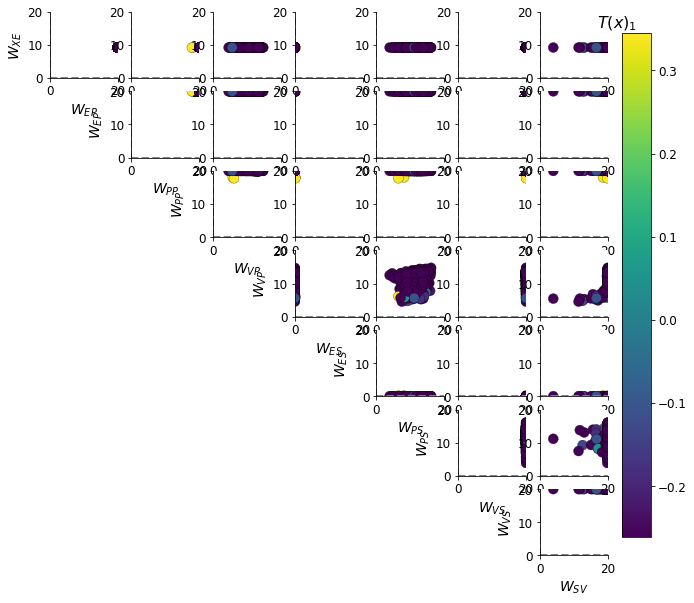

In [66]:
Zs, cs, axs = dsn_pairplots([best_model], 'Zs', system, [ME_it], c_str='T_x1',
                            xlims=[0,20], ylims=[0,20])


0
dist (1000, 2)


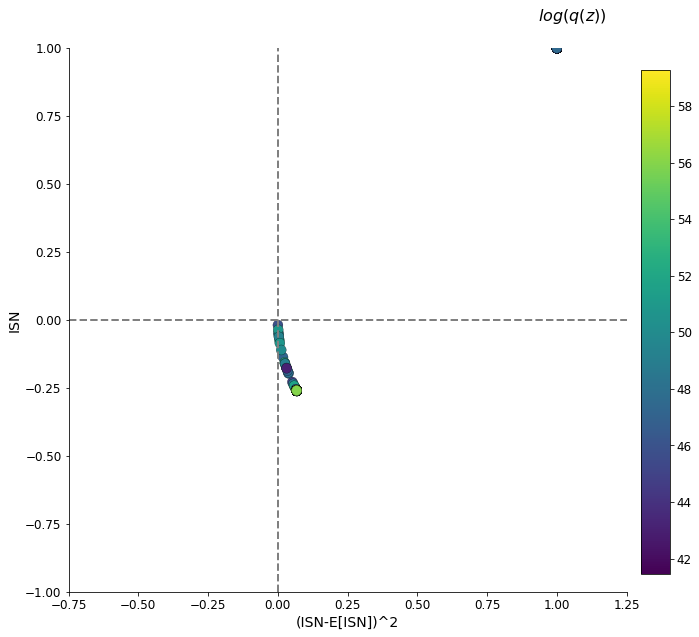

In [67]:
T_xs, cs, axs = dsn_pairplots([best_model], 'T_xs', system,  [ME_it], 
                              outlier_stds=2, xlims=[-1,1], ylims=[-1,1])    

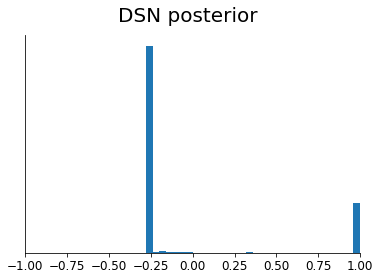

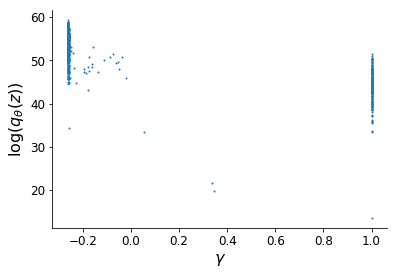

In [72]:
log_q_z = cs[0]
gamma = T_xs[0][:,0]

plt.figure()
plt.suptitle('DSN posterior', fontsize=20)
plt.hist(gamma, bins=50, range=histrange)
plt.xlim([-1,1])

#plt.xticks([])
plt.yticks([])
plt.show()

plt.figure()
plt.scatter(gamma, log_q_z, s=1)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\log (q_\theta(z))$')
plt.show()

In [74]:
from dsn.util.dsn_util import grid_search

n_gs = 100000

# grid search
Z_threshs = []
gamma_threshs = []

Z_thresh, mu, Sigma = grid_search(system, n_gs)
Z = tf.placeholder(tf.float64, (1,None,system.D))
T_x = system.compute_suff_stats(Z)
with tf.Session() as sess:
    _T_x = sess.run(T_x, {Z:np.expand_dims(Z_thresh, 0)})
gamma_thresh = _T_x[0,:,0]


AttributeError: 'list' object has no attribute 'shape'

98627 / 100000 = 98.63%


(-1, 1)

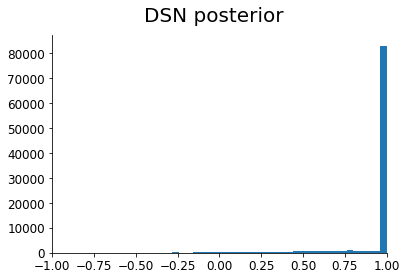

In [77]:
print('%d / %d = %.2f%%' % (Z_thresh.shape[0], n_gs, 100*float(Z_thresh.shape[0])/n_gs))

plt.figure()
plt.suptitle('DSN posterior', fontsize=20)
plt.hist(gamma_thresh, bins=50, range=histrange)
plt.xlim([-1,1])

In [9]:
from dsn.util.dsn_util import linregress

beta_dsns = []
beta_gss = []
r2_dsns = []
r2_gss = []
for i in range(num_silenced):
    y = np.expand_dims(gammas[i], 1)
    X = Zs[i]
    beta, r2 = linregress(y, X)
    beta_dsns.append(beta)
    r2_dsns.append(r2)
    
    y_th = np.expand_dims(gamma_threshs[i], 1)
    X_th = Z_threshs[i]
    beta_th, r2_th = linregress(y_th, X_th)
    beta_gss.append(beta_th)
    r2_gss.append(r2_th)

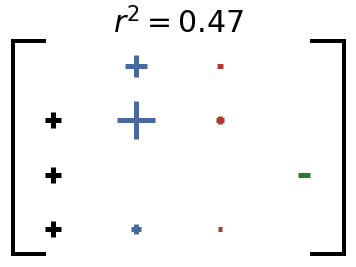

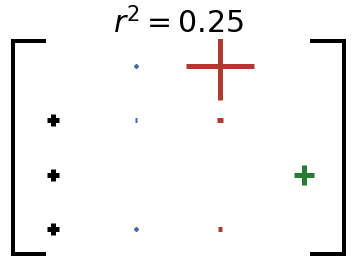

In [10]:
from dsn.util.plot_util import plot_V1_vec
for k in range(num_silenced):
    silenced = silenced_pops[k]
    r2 = r2_dsns[k]
    v = beta_dsns[k][:-1]
    label = r'$r^2 = %.2f$' % r2
    plot_V1_vec(v, label)

    

ABC accepted 1300 / 2000
(1, 1300, 3)
ABC accepted 211 / 2000
ABC accepted 1007 / 10000
(1, 1007, 3)
ABC accepted 16 / 2000
ABC accepted 69 / 10000
ABC accepted 353 / 50000
(1, 353, 3)
ABC accepted 4 / 2000
ABC accepted 8 / 10000
ABC accepted 74 / 50000
ABC accepted 355 / 250000
(1, 355, 3)
ABC samples, S=0


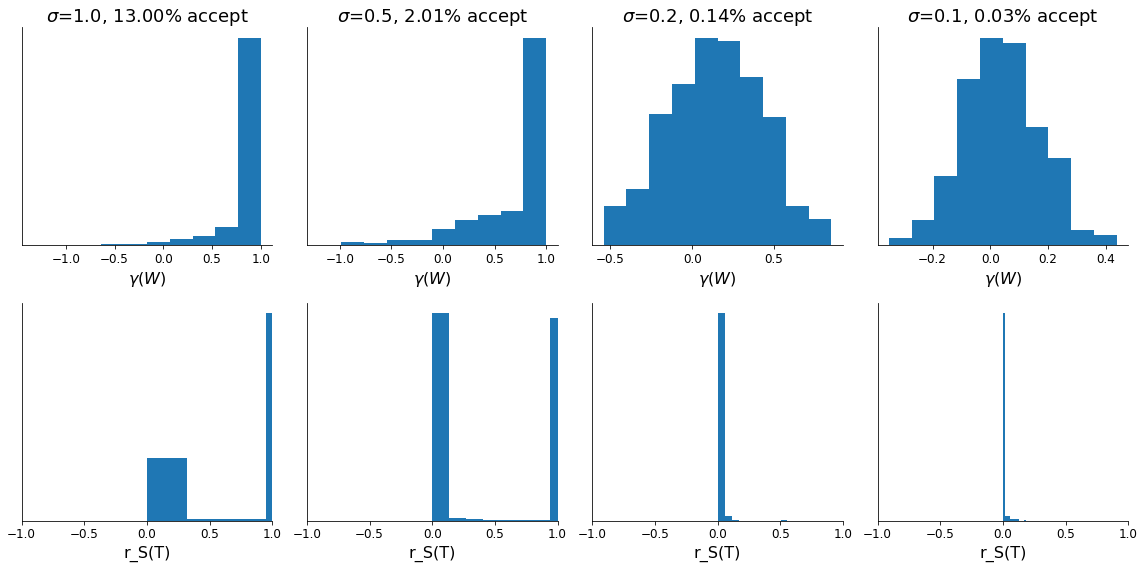

ABC accepted 1491 / 2000
(1, 1491, 3)
ABC accepted 359 / 2000
(1, 359, 3)
ABC accepted 3 / 2000
ABC accepted 27 / 10000
ABC accepted 144 / 50000
ABC accepted 744 / 250000
(1, 744, 3)
ABC accepted 3 / 2000
ABC accepted 3 / 10000
ABC accepted 18 / 50000
ABC accepted 85 / 250000
ABC accepted 483 / 1250000
(1, 483, 3)
ABC samples, V=0


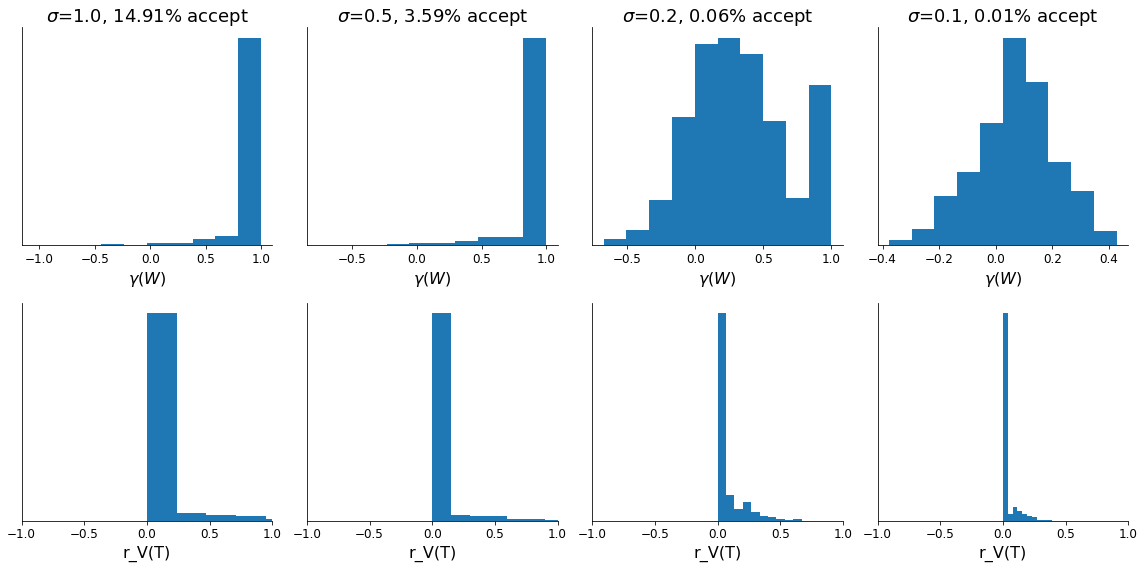

In [45]:
from dsn.util.dsn_util import abc_sample

n_abc = 2000
accept_th = 300
sigmas = [1.0, 0.5, 0.2, 0.1]
num_sigmas = len(sigmas)
inds = np.array([True,False,True])

for i in range(2):
    silenced = silenced_pops[i]
    system = systems[i]
    T_x_abcs = []
    n_accepteds = []
    n_abcs = []
    for j in range(num_sigmas):
        sigma = sigmas[j]
        _n = n_abc
        n_accepted = 0
        while (n_accepted < accept_th):
            Z_abc = abc_sample(system, _n, sigma=sigma, inds=inds)
            n_accepted = Z_abc.shape[0]
            print("ABC accepted %d / %d" % (n_accepted, _n))
            _n = 5*_n
        n_abcs.append(_n)
        n_accepteds.append(n_accepted)
        
        Z = tf.placeholder(tf.float64, shape=(1,None,system.D))
        T_x = system.compute_suff_stats(Z)
        with tf.Session() as sess:
            _T_x = sess.run(T_x, {Z:np.expand_dims(Z_abc, 0)})
        print(_T_x.shape)
        T_x_abcs.append(_T_x)
        
    fig, axs = plt.subplots(2,num_sigmas, figsize=(4*num_sigmas,8))
    print('ABC samples, %s=0' % silenced)
    for k in range(2):
        if (k==0):
            ind = 0
            label = r'$\gamma(W)$'
        elif (k==1):
            ind = 2
            label = 'r_%s(T)' % silenced
        for j in range(num_sigmas):
            sigma = sigmas[j]
            axs[k,j].hist(T_x_abcs[j][0,:,ind])
            axs[k,j].set_xlabel(label)
            if (k==0):
                axs[k,j].set_title(r'$\sigma$=%.1f, %.2f%% accept' % (sigma, 100*n_accepteds[j]/ n_abcs[j]))
            if (k==1):
                axs[k,j].set_xlim([-1,1])
            axs[k,j].set_yticks([])
    plt.tight_layout()
    plt.show()



        


In [12]:
sessions, tf_vars, feed_dicts = load_DSNs(best_models, ME_its)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/V1Circuit/V1Circuit_D=8_ISN_0.00E+00_2.50E-01_S=0_flow=1R_8M_2L_10U_M_A_c=10_rs=3/model-7
Loaded DGM in 3.09 seconds
INFO:tensorflow:Restoring parameters from models/V1Circuit/V1Circuit_D=8_ISN_0.00E+00_2.50E-01_V=0_flow=1R_8M_2L_10U_M_A_c=2_rs=4/model-14


In [13]:
# Sample DSN and calculate Hessians
np.random.seed(0)

M = 10000
tol = 1e-2

Hs = []
Ds = []
Vs = []

w0s = []
z0s = []
Zs = []
T_xs = []
for k in range(num_silenced):
    silenced = silenced_pops[k]
    model_dir = best_models[k]
    ME_it = ME_its[k]
    
    sess = sessions[k]
    system = systems[k]
    tf_vars_k = tf_vars[k]

    W, Z, Z_INV, log_q_Z, batch_norm_mus, batch_norm_sigmas, batch_norm_means, batch_norm_vars  = tf_vars_k
    T_x = system.compute_suff_stats(Z)
    feed_dict = feed_dicts[k]
    
    #Get large sample from model to estimate mode
    _W = np.random.normal(0.0, 1.0, (1,M,system.D))
    feed_dict.update({W:_W})
    _Z, _T_x = sess.run([Z, T_x], feed_dict)
    Zs.append(_Z)
    T_xs.append(_T_x)
    
    # Get generative sample closest to ISN(W) = 0
    z0_inds = np.argsort(np.abs(_T_x[0,:,0]))
    z0_ind = z0_inds[0] # Take closest to ISN(W) = 0
    z0 = _Z[0,z0_ind]
    w0 = np.expand_dims(_W[:,z0_ind,:], 1)
    
    print(_Z[0,z0_inds[:5]])

    print('get dgm hessian')
    H, w0, z0 = get_dgm_hessian(model_dir, ME_it, w0, tol, system, tf_vars_k, feed_dict, sess)
    
    Hs.append(H)
    D, V = np.linalg.eig(H)
    inds = np.argsort(D)
    D = D[inds]
    V = V[:,inds]
    Ds.append(D)
    Vs.append(V)
    
    w0s.append(w0)
    z0s.append(z0)

[[ 5.22904674  5.18155174 13.31204629  4.69857657 11.6900075  11.00205384
   3.27510841 14.56443768]
 [ 5.93744918  4.77775883 13.30203385  4.69006364 11.36104109 10.04075473
   2.78871704 14.19147111]
 [ 5.26329117  5.15955853 13.30762147  4.38728841  8.7979061  12.48392973
   2.90676207 14.47075428]
 [ 4.59172673  5.60475289 13.31914559  4.80583969  9.66655943 10.39914683
   2.14186797 14.0852809 ]
 [ 5.33790007  5.11749643 13.31829606  4.46340509  9.53055957  9.50178545
   4.68448227 13.85191923]]
get dgm hessian
Hessian file already exists.
0 5.031195260762653
[-0.20894577  0.12869609  0.21657421 -1.25091053 -1.25172593  0.01444789
 -0.52504759 -1.49436344] [-0.62737906  0.53134025  0.73863413  1.55945047 -0.32610529  0.3518915
 -0.10084849  2.46220766]
1 4.178985019935853
[-0.20894577  0.12869609  0.21657421 -1.25091053 -1.25172593  0.01444789
 -0.52504759 -1.49436344] [-0.20223675 -0.75420244  1.59489071  0.6987373   0.06396499  2.645151
 -1.31842649 -0.18960811]
2 2.182469796627

In [17]:
from dsn.util.dsn_util import get_perturbs
    

n_perturb = 100
T_x_perturb_v1s = []
delta_v1s = []
T_x_perturb_dsns = []
delta_dsns = []
T_x_perturb_gss = []
delta_gss = []
for i in range(num_silenced):
    z0 = z0s[i]
    system = systems[i]
    
    T_x_perturb_v1 = np.zeros((system.D, n_perturb))
    delta_v1 = np.zeros((system.D, n_perturb))
    V = Vs[i]
    T_x_perturb_v1, delta_v1, Z_perturb_v1 = get_perturbs(system, V, z0, n_perturb)
    T_x_perturb_v1s.append(T_x_perturb_v1)
    delta_v1s.append(delta_v1)
    
    beta_dsn = beta_dsns[i]
    T_x_perturb_dsn, delta_dsn, Z_perturb_dsn = get_perturbs(system, np.expand_dims(beta_dsn, 1), z0, n_perturb)
    T_x_perturb_dsns.append(T_x_perturb_dsn)
    delta_dsns.append(delta_dsn)
    
    beta_gs = beta_gss[i]
    T_x_perturb_gs, delta_gs, Z_perturb_gs = get_perturbs(system, np.expand_dims(beta_gs, 1), z0, n_perturb)
    T_x_perturb_gss.append(T_x_perturb_gs)
    delta_gss.append(delta_gs)

creating graph
graph ready
v 1
got perturb
v 2
got perturb
v 3
got perturb
v 4
got perturb
v 5
got perturb
v 6
got perturb
v 7
got perturb
v 8
got perturb
creating graph
graph ready
v 1
got perturb
creating graph
graph ready
v 1
got perturb
creating graph
graph ready
v 1
got perturb
v 2
got perturb
v 3
got perturb
v 4
got perturb
v 5
got perturb
v 6
got perturb
v 7
got perturb
v 8
got perturb
creating graph
graph ready
v 1
got perturb
creating graph
graph ready
v 1
got perturb


In [24]:
print(delta_v1s[0].shape)
print(T_x_perturb_v1s[0][0].shape)

(8, 100)
(100, 3)


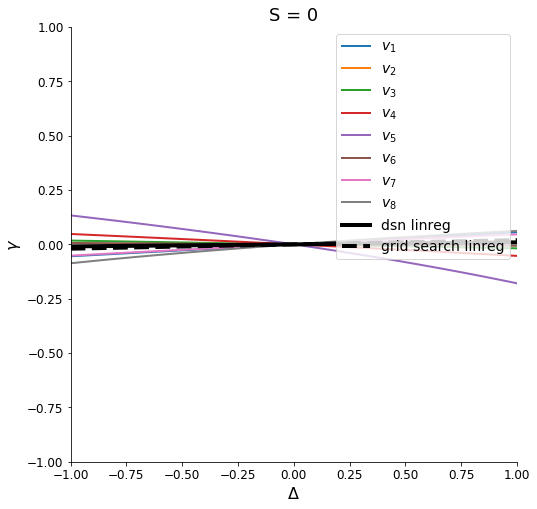

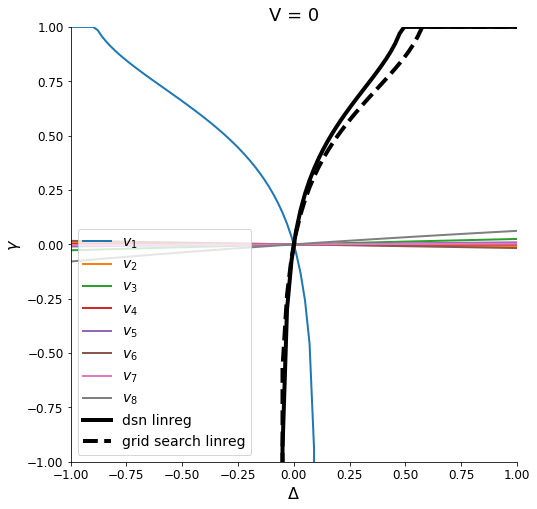

In [26]:
xmax = 1
for i in range(2):
    silenced = silenced_pops[i]
    plt.figure(figsize=(8,8))
    for j in range(system.D):
        plt.plot(delta_v1s[i][j], T_x_perturb_v1s[i][j,:,0])
    plt.plot(delta_dsns[i][0], T_x_perturb_dsns[i][0,:,0], 'k-', lw=4)
    plt.plot(delta_gss[i][0], T_x_perturb_gss[i][0,:,0], 'k--', lw=4)
    v1_labels = [r'$v_%d$' % i for i in range(1,system.D+1)]
    plt.legend(v1_labels + ['dsn linreg', 'grid search linreg'])
    plt.xlim([-xmax, xmax])
    plt.ylim([-1, 1])
    plt.ylabel(r'$\gamma$')
    plt.xlabel(r'$\Delta$')
    plt.title('%s = 0' % silenced)
    plt.show()

In [27]:
print(Ds)

[array([-3.52484719e+04, -1.14072532e+02, -7.22597810e+01, -1.17818471e+01,
       -5.36865689e+00, -1.46463581e+00, -1.09774501e+00,  1.66934214e-01]), array([-1.28493740e+07, -6.35660236e+04, -2.21819930e+02, -1.47306947e+00,
       -9.45388801e-01, -5.86584964e-01,  6.08532755e-01,  4.30831186e+01])]


V = 0
(10000, 4)


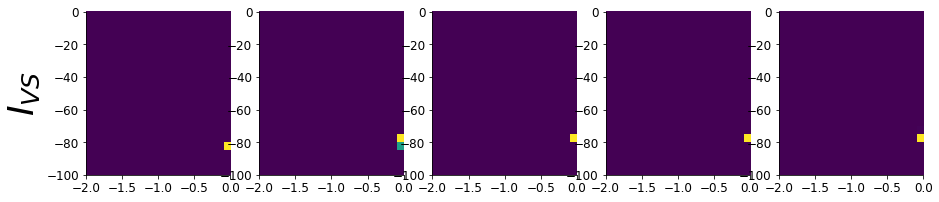

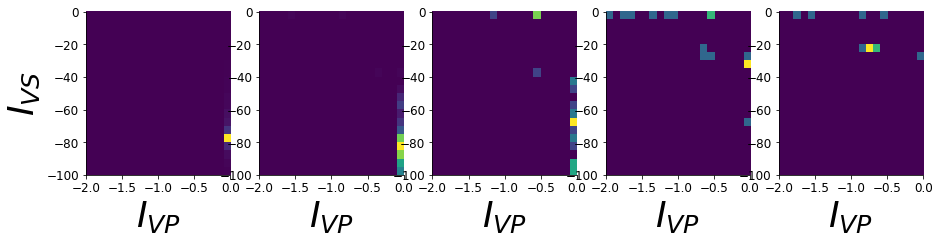

In [77]:
gamma_intervals = np.array([-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
fontsize = 36
for i in [1]:
    silenced = silenced_pops[i]
    print('%s = 0' % silenced)
    system = systems[i]
    Z = tf.placeholder(tf.float64, (1,None,system.D))
    
    r_t_tf = system.simulate(Z)
    _Z = Zs[i]
    gamma = T_xs[i][0,:,0]
    
    with tf.Session() as sess:
        r_t = sess.run(r_t_tf, {Z:_Z})
    
    
    W_EE = 1.0
    W_XE = _Z[0,:,0]
    W_EP = -_Z[0,:,1]
    W_PP = -_Z[0,:,2]
    W_VP = -_Z[0,:,3]
    W_ES = -_Z[0,:,4]
    W_PS = -_Z[0,:,5]
    W_VS = -_Z[0,:,6]
    W_SV = -_Z[0,:,7]

    I = 1.0

    r_ss = r_t[-1,0,:,:,0]
    print(r_ss.shape)
    r_E_ss = r_ss[:,0]
    r_P_ss = r_ss[:,1]
    r_S_ss = r_ss[:,2]
    r_V_ss = r_ss[:,3]

    I_EE = W_EE*r_E_ss
    I_EP = W_EP*r_P_ss
    I_ES = W_ES*r_S_ss
    
    I_SE = W_XE*r_E_ss
    I_SV = W_SV*r_V_ss

    I_VE = W_XE*r_E_ss
    I_VP = W_VP*r_P_ss
    I_VS = W_VS*r_S_ss
 
    min_I_SE = -0.5
    max_I_SE = 2.2
    min_I_SV = -80
    max_I_SV = -20
    
    min_I_VS = -100
    max_I_VS = 0
    min_I_VP = -2
    max_I_VP = 0
    
    num_plts = gamma_intervals.shape[0] - 1
    
    
    if (i==0):
        for i in range(2):
            fig, axs = plt.subplots(1,num_plts//2, figsize=(15,3))
            for j in range(num_plts//2):
                ind = 5*i+j
                ax = axs[j]
                a = gamma_intervals[ind]
                b = gamma_intervals[ind+1]
                valid_inds = np.logical_and(a < gamma, gamma < b)
                xedges = [min_I_SE, max_I_SE]
                yedges = [min_I_SV, max_I_SV]
                ax.hist2d(I_SE[valid_inds==1], I_SV[valid_inds==1],
                              range=[xedges,yedges], bins=50)
                ax.set_xlim(xedges)
                ax.set_ylim(yedges)
                if (i==1):
                    ax.set_xlabel(r'$I_{SE}$', fontsize=fontsize)
                if (j==0):
                    ax.set_ylabel(r'$I_{SV}$', fontsize=fontsize)
            plt.show()
            
    else:
        for i in range(2):
            fig, axs = plt.subplots(1,num_plts//2, figsize=(15,3))
            for j in range(num_plts//2):
                ind = 5*i+j
                ax = axs[j]
                a = gamma_intervals[ind]
                b = gamma_intervals[ind+1]
                valid_inds = np.logical_and(a < gamma, gamma < b)
                xedges = [min_I_VP, max_I_VP]
                yedges = [min_I_VS, max_I_VS]
                ax.hist2d(I_VP[valid_inds==1], I_VS[valid_inds==1],
                              range=[xedges,yedges], bins=20)
                ax.set_xlim(xedges)
                ax.set_ylim(yedges)
                if (i==1):
                    ax.set_xlabel(r'$I_{VP}$', fontsize=fontsize)
                if (j==0):
                    ax.set_ylabel(r'$I_{VS}$', fontsize=fontsize)
            plt.show()

    

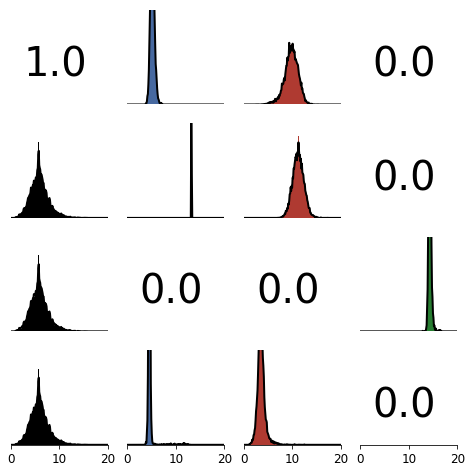

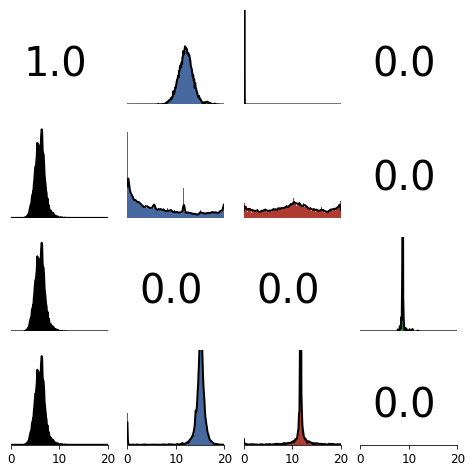

In [10]:
black = 'k'
blue = np.array([71, 105, 160]) / 255.0
red = np.array([175, 58, 49]) / 255.0
green = np.array([39, 124, 49]) / 255.0

c = [['k', blue, red, green], \
         ['k', blue, red, green], \
         ['k', blue, red, green], \
         ['k', blue, red, green]]

vinds = [[None, 1, 4, None], \
         [   0, 2, 5, None], \
         [   0, None, None, 7], \
         [   0, 3, 6, None]]

num_bins = 200
bins = np.linspace(0.0, 20.0, num_bins)
contour_x =  np.linspace(0.0, 20.0, num_bins)

for k in range(num_silenced):
    silenced = silenced_pops[k]
    _Z = Zs[k][0]
    fig, axs = plt.subplots(4, 4, figsize=(8,8))
    for i in range(4):
        for j in range(4):
            zind = vinds[i][j]
            if zind is not None:
                n, _, _ = axs[i][j].hist(_Z[:,zind], bins=bins, color=c[i][j],
                               histtype='bar', density=True)
                # contour
                kde = scipy.stats.gaussian_kde(_Z[:,zind], 0.025)

                axs[i][j].plot(contour_x, kde(contour_x), 'k-')
            else:
                if (i==0 and j==0):
                    text = '1.0'
                else:
                    text = '0.0'
                axs[i][j].text(2.5, 0.15, text, fontsize=40)


            if (i < 3):
                axs[i][j].spines['bottom'].set_visible(False)
                axs[i][j].set_xticks([])
            axs[i][j].set_xlim([0,20])
            axs[i][j].set_ylim([0,.5])
            axs[i][j].spines['left'].set_visible(False)
            axs[i][j].set_yticks([])

    plt.savefig('notebooks/images/V1/V1_DSN_marginals_ISN_%s=0.png' % silenced)

    plt.show()

In [11]:
a = 0.0
b = 20.0

res = 101

xs_pert = []
T_xs_pert = []
Zs_pert = []
eigvec_oris = []
for k in range(num_silenced):
    print(k)
    silenced = silenced_pops[k]
    system = systems[k]
    
    D = Ds[k]
    V = Vs[k]
    w_max = w_maxes[k]
    z_max = z_maxes[k]
    
    inds = np.argsort(D)
    
    
    a_alphas = []
    b_alphas = []
    for i in range(system.D):
        d = D[i]
        v = V[:,i]
        border_scales_a = (a - z_max) / v
        border_scales_b = (b - z_max) / v
        
        a_alphas.append(np.min(np.abs(border_scales_a)))
        b_alphas.append(np.min(np.abs(border_scales_b)))
    
    max_abs_alpha = min(min(a_alphas), min(b_alphas))
    
    Z = tf.placeholder(tf.float64, (1,None,system.D))
    T_x = system.compute_suff_stats(Z)
    x = system.simulate(Z)
    
    _T_xs = []
    _xs = []
    _Zs = []
    eigvec_ori = np.zeros((system.D))
    for i in range(system.D):
        v = V[:,i]
        _Z = np.zeros((1,res,system.D))
        for j in range(system.D):
            _Z[0,:,j] = np.linspace(z_max[j] - max_abs_alpha*v[j],  z_max[j] + max_abs_alpha*v[j], res)
        
        with tf.Session() as sess:
            _x, _T_x = sess.run([x, T_x], {Z:_Z})
        _xs.append(_x)
        _T_xs.append(_T_x)
        _Zs.append(_Z)
        eigvec_ori[i] = np.sign(_T_x[0,res//2+1,0] - _T_x[0,res//2-1,0])
        
        
    xs_pert.append(_xs)
    T_xs_pert.append(_T_xs)
    Zs_pert.append(_Zs)
    eigvec_oris.append(eigvec_ori)
        
for k in range(num_silenced):
    for i in range(system.D):
        if (eigvec_oris[k][i] == -1):
            print("flipping", k, i)
            Vs[k][i] = -Vs[k][i]

0
1
flipping 0 2
flipping 0 3
flipping 0 4
flipping 0 5
flipping 1 0
flipping 1 1
flipping 1 3
flipping 1 5


In [62]:
for k in range(num_silenced):
    silenced = silenced_pops[k]
    D = Ds[k]
    V = Vs[k]    

    space = 0.01
    for i in range(system.D):
        d_i = D[i]
        v = V[:,i]
        label = r'$\lambda_%d = %.2E$' % (i+1, d_i)
        save_fname = 'notebooks/images/V1/DSN_V1_ISN_%s=0_ax%d.png' % (silenced, i+1)
        plot_V1_vec(v, label, save_fname)


NameError: name 'Ds' is not defined

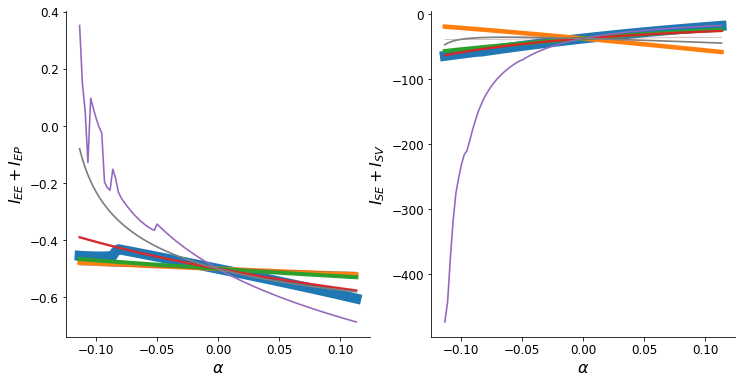

In [39]:
fontsize = 24
cmaps = [plt.get_cmap('Greys'), plt.get_cmap('Blues'), plt.get_cmap('Reds'), plt.get_cmap('Greens')]
for k in [0]:
    silenced = silenced_pops[k]
    D = Ds[k]
    V = Vs[k]
    _Zs = Zs_pert[k]
    _T_xs = T_xs_pert[k]
    _xs = xs_pert[k]
    eigvec_ori = eigvec_oris[k]
    
    log_abs_D = np.log10(np.abs(D))
    max_log_abs_D = np.max(log_abs_D)
    
    fig, axs = plt.subplots(1,2,figsize=(12,6))
    for i in range(system.D):
        _y = 0.2
        strength = log_abs_D[i]/max_log_abs_D
        c = _y + (1-_y)*strength
        
        alpha = eigvec_ori[i]*np.linspace(-max_abs_alpha, max_abs_alpha, res)
        gamma = _T_xs[i][0,:,0]
        r_t = _xs[i][:,0,:,:,0] # [T,M,4]
        M = r_t.shape[1]

        W_EE = 1.0
        W_XE = _Zs[i][0,:,0]
        W_EP = -_Zs[i][0,:,1]
        W_PP = -_Zs[i][0,:,2]
        W_VP = -_Zs[i][0,:,3]
        W_ES = -_Zs[i][0,:,4]
        W_PS = -_Zs[i][0,:,5]
        W_VS = -_Zs[i][0,:,6]
        W_SV = -_Zs[i][0,:,7]
        
        I = 1.0

        r_ss = r_t[-1]
        r_E_ss = r_ss[:,0]
        r_P_ss = r_ss[:,1]
        r_S_ss = r_ss[:,2]
        r_V_ss = r_ss[:,3]

        I_EE = W_EE*r_E_ss
        I_EP = W_EP*r_P_ss
        I_ES = W_ES*r_S_ss
        
        I_SE = W_XE*r_E_ss
        I_SV = W_SV*r_V_ss

        
        axs[0].plot(alpha, I_EE + I_EP + I_ES, lw=strength*10)
        axs[0].set_ylabel(r'$I_{EE} + I_{EP}$')
        axs[0].set_xlabel(r'$\alpha$')
        
        axs[1].plot(alpha, I_SE + I_SV, lw=strength*10)
        axs[1].set_ylabel(r'$I_{SE} + I_{SV}$')
        axs[1].set_xlabel(r'$\alpha$')
    plt.show()
    

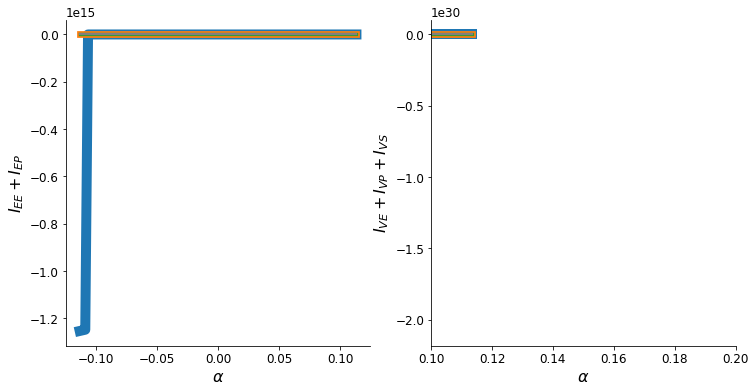

In [52]:
fontsize = 24
cmaps = [plt.get_cmap('Greys'), plt.get_cmap('Blues'), plt.get_cmap('Reds'), plt.get_cmap('Greens')]
for k in [1]:
    silenced = silenced_pops[k]
    D = Ds[k]
    V = Vs[k]
    _Zs = Zs_pert[k]
    _T_xs = T_xs_pert[k]
    _xs = xs_pert[k]
    eigvec_ori = eigvec_oris[k]
    
    log_abs_D = np.log10(np.abs(D))
    max_log_abs_D = np.max(log_abs_D)
    
    fig, axs = plt.subplots(1,2,figsize=(12,6))
    for i in range(system.D):
        _y = 0.2
        strength = log_abs_D[i]/max_log_abs_D
        c = _y + (1-_y)*strength
        
        alpha = eigvec_ori[i]*np.linspace(-max_abs_alpha, max_abs_alpha, res)
        gamma = _T_xs[i][0,:,0]
        r_t = _xs[i][:,0,:,:,0] # [T,M,4]
        M = r_t.shape[1]

        W_EE = 1.0
        W_XE = _Zs[i][0,:,0]
        W_EP = -_Zs[i][0,:,1]
        W_PP = -_Zs[i][0,:,2]
        W_VP = -_Zs[i][0,:,3]
        W_ES = -_Zs[i][0,:,4]
        W_PS = -_Zs[i][0,:,5]
        W_VS = -_Zs[i][0,:,6]
        W_SV = -_Zs[i][0,:,7]
        
        I = 1.0

        r_ss = r_t[-1]
        r_E_ss = r_ss[:,0]
        r_P_ss = r_ss[:,1]
        r_S_ss = r_ss[:,2]
        r_V_ss = r_ss[:,3]

        I_EE = W_EE*r_E_ss
        I_EP = W_EP*r_P_ss
        I_ES = W_ES*r_S_ss
        
        I_VE = W_XE*r_E_ss
        I_VP = W_VP*r_P_ss
        I_VS = W_VS*r_S_ss

        
        axs[0].plot(alpha, gamma, lw=strength*10)
        axs[0].set_ylabel(r'$I_{EE} + I_{EP}$')
        axs[0].set_xlabel(r'$\alpha$')
        
        axs[1].plot(alpha, I_VE + I_VP + I_VS, lw=strength*10)
        axs[1].set_ylabel(r'$I_{VE} + I_{VP} + I_{VS}$')
        axs[1].set_xlabel(r'$\alpha$')
        axs[1].set_xlim([.1,.2])
    plt.show()
    

In [30]:
print(system.z_labels)


['$W_{XE}$', '$W_{EP}$', '$W_{PP}$', '$W_{VP}$', '$W_{ES}$', '$W_{PS}$', '$W_{VS}$', '$W_{SV}$']


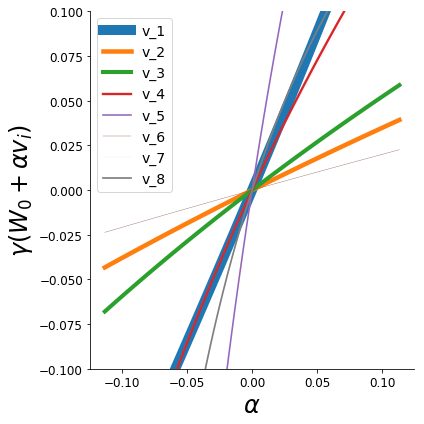

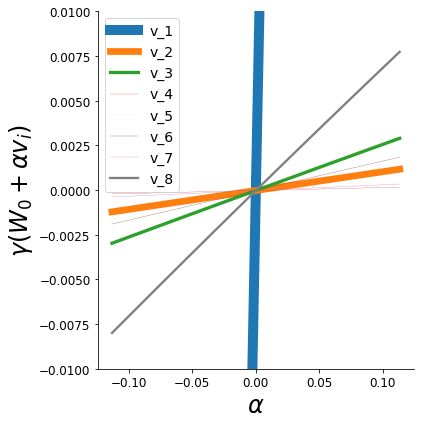

In [31]:
fontsize = 24
ylims = [ [-0.1, 0.1], [-0.01, 0.01]]
for k in range(num_silenced):
    silenced = silenced_pops[k]
    D = Ds[k]
    V = Vs[k]
    _T_xs = T_xs_pert[k]
    
    log_abs_D = np.log10(np.abs(D))
    max_log_abs_D = np.max(log_abs_D)

    x = np.linspace(-max_abs_alpha, max_abs_alpha, res)
    plt.figure(figsize=(6,6))
    legendstrs = []
    cs = []
    ds = []
    for i in range(system.D):
        gamma = _T_xs[i][0,:,0]
        zeroind = np.argmin(np.abs(gamma))
        if (eigvec_oris[k][i] < 0):
            _x = -x
        else:
            _x = x
        cmap = plt.get_cmap('Oranges')
        _y = 0.2
        strength = log_abs_D[i]/max_log_abs_D
        c = _y + (1-_y)*strength
        ds.append(log_abs_D[i])
        cs.append(c)
        plt.plot(_x, gamma, '-', lw=strength*10)
        legendstrs.append('v_%d' % (i+1))
    plt.legend(legendstrs)
    plt.ylim(ylims[k])

    plt.xlabel(r'$\alpha$', fontsize=fontsize)
    plt.ylabel(r'$\gamma(W_0 + \alpha v_i)$', fontsize=fontsize)
    plt.tight_layout()
    fname = 'notebooks/images/V1/V1_ISN_hess_perturb_%s=0.png' % silenced
    plt.savefig(fname)
    plt.show()

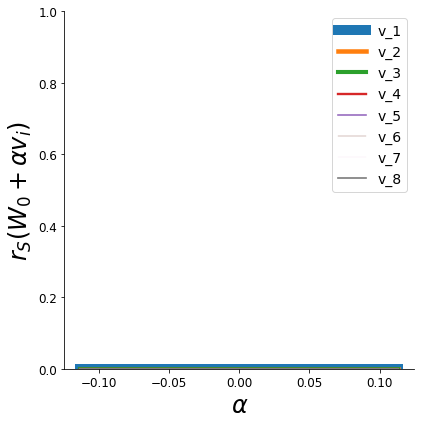

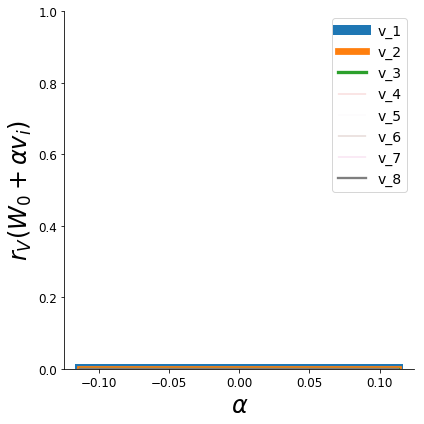

In [32]:
for k in range(num_silenced):
    silenced = silenced_pops[k]
    D = Ds[k]
    V = Vs[k]
    _T_xs = T_xs_pert[k]
    
    log_abs_D = np.log10(np.abs(D))
    max_log_abs_D = np.max(log_abs_D)

    x = np.linspace(-max_abs_alpha, max_abs_alpha, res)
    plt.figure(figsize=(6,6))
    legendstrs = []
    cs = []
    ds = []
    for i in range(system.D):
        r_sil = _T_xs[i][0,:,2]
        gamma = _T_xs[i][0,:,0]
        zeroind = np.argmin(np.abs(gamma))
        if (eigvec_oris[k][i]):
            _x = -x
        else:
            _x = x
        cmap = plt.get_cmap('Oranges')
        _y = 0.2
        strength = log_abs_D[i]/max_log_abs_D
        c = _y + (1-_y)*strength
        ds.append(log_abs_D[i])
        cs.append(c)
        plt.plot(_x, r_sil, '-', lw=strength*10)
        legendstrs.append('v_%d' % (i+1))
    plt.legend(legendstrs)
    plt.ylim([0, 1])

    plt.xlabel(r'$\alpha$', fontsize=fontsize)
    plt.ylabel(r'$r_%s(W_0 + \alpha v_i)$' % silenced, fontsize=fontsize)
    plt.tight_layout()
    plt.savefig('notebooks/images/V1/V1_silenced_hess_perturb_%s=0.png' % silenced)
    plt.show()

In [19]:
a = 0.0
b = 20.0

res = 1001

lim1s = []
lim2s = []
T_xs_pert = []
alphas = []
for k in range(num_silenced):
    silenced = silenced_pops[k]
    system = systems[k]
    
    D = Ds[k]
    V = Vs[k]
    w_max = w_maxes[k]
    z_max = z_maxes[k]
    
    Z = tf.placeholder(tf.float64, (1,None,system.D))
    T_x = system.compute_suff_stats(Z)
    
    _T_xs = []
    Alpha = []
    _lim1 = np.zeros((system.D,))
    _lim2 = np.zeros((system.D,))
    for i in range(system.D):
        d = D[i]
        v = V[:,i]
        
        border_scales_a = (a - z_max) / v
        border_scales_b = (b - z_max) / v
        
        all_scales = np.concatenate((border_scales_a, border_scales_b), axis=0)
        neg_scales = all_scales[all_scales<0]
        pos_scales = all_scales[all_scales>0]
        
        lim1 = np.max(neg_scales)
        lim2 = np.min(pos_scales)
        _lim1[i] = lim1
        _lim2[i] = lim2
        
        print(lim1, lim2)
        
        _Z = np.zeros((1,res,system.D))
        for j in range(system.D):
            _Z[0,:,j] = np.linspace(z_max[j] + lim1*v[j],  z_max[j] + lim2*v[j], res)
        
        with tf.Session() as sess:
            _T_x = sess.run(T_x, {Z:_Z})
        _T_xs.append(_T_x)
        Alpha.append(np.linspace(lim1, lim2, res))
        
    alphas.append(np.array(Alpha))
    T_xs_pert.append(_T_xs)
    
    lim1s.append(_lim1)
    lim2s.append(_lim2)

        

-6.688088190111651 13.311968780648924
-4.435139226076554 17.250306550877752
-5.634113454319265 14.830807492522379
-6.190173772661026 13.110846592154664
-7.898226301267685 12.430344509946721
-6.6313950049126325 18.35592695866827
-11.358230534050982 10.098823314937038
-9.393856381489181 6.054935864988129
-0.1138189122775267 19.886185176687388
-8.71328184906684 11.288899003946517
-11.88600773425825 8.558486024780944
-0.7257186064629566 19.497865931332758
-5.385762023103424 14.925813015211293
-11.762025142168419 8.683608475546347
-14.545881051594277 5.517787409251792
-6.021006345387154 14.617637067060771


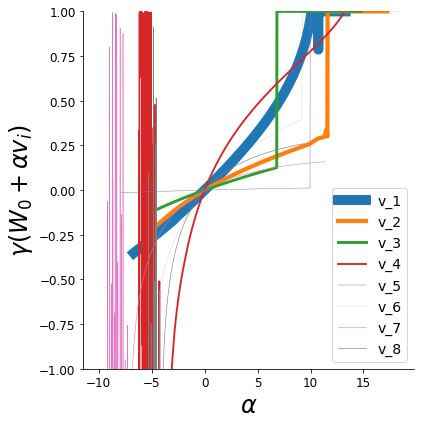

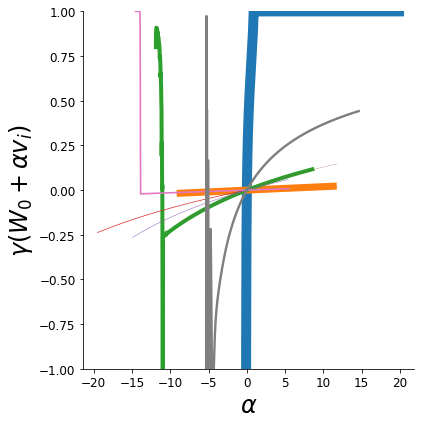

In [20]:
fontsize = 24
for k in range(num_silenced):
    silenced = silenced_pops[k]
    D = Ds[k]
    V = Vs[k]
    _T_xs = T_xs_pert[k]
    Alpha = alphas[k]
    
    log_abs_D = np.log10(np.abs(D))
    max_log_abs_D = np.max(log_abs_D)

    plt.figure(figsize=(6,6))
    legendstrs = []
    cs = []
    ds = []
    for i in range(system.D):
        gamma = _T_xs[i][0,:,0]
        zeroind = np.argmin(np.abs(gamma))
        if (gamma[zeroind + 1] < gamma[zeroind - 1]):
            x = -Alpha[i]
        else:
            x = Alpha[i]
        cmap = plt.get_cmap('Oranges')
        _y = 0.2
        strength = log_abs_D[i]/max_log_abs_D
        c = _y + (1-_y)*strength
        ds.append(log_abs_D[i])
        cs.append(c)
        plt.plot(x, gamma, '-', lw=strength*10)
        legendstrs.append('v_%d' % (i+1))
    if (silenced == 'S'):
        plt.legend(legendstrs)
    plt.ylim([-1, 1])

    plt.xlabel(r'$\alpha$', fontsize=fontsize)
    plt.ylabel(r'$\gamma(W_0 + \alpha v_i)$', fontsize=fontsize)
    plt.tight_layout()
    fname = 'notebooks/images/V1/V1_ISN_hess_perturb_full_%s=0.png' % silenced
    plt.savefig(fname)
    plt.show()

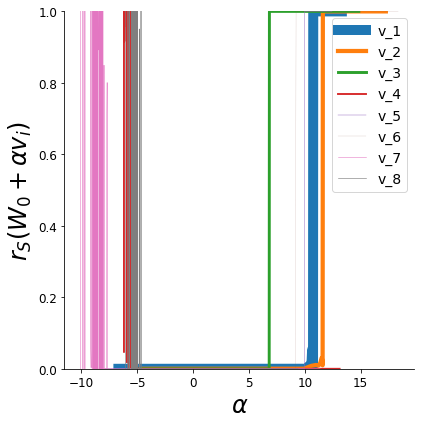

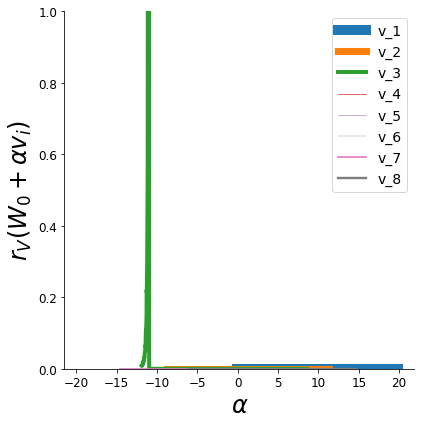

In [21]:
fontsize = 24
for k in range(num_silenced):
    silenced = silenced_pops[k]
    D = Ds[k]
    V = Vs[k]
    _T_xs = T_xs_pert[k]
    Alpha = alphas[k]
    
    log_abs_D = np.log10(np.abs(D))
    max_log_abs_D = np.max(log_abs_D)

    plt.figure(figsize=(6,6))
    legendstrs = []
    cs = []
    ds = []
    for i in range(system.D):
        r_sil = _T_xs[i][0,:,2]
        gamma = _T_xs[i][0,:,0]
        zeroind = np.argmin(np.abs(gamma))
        if (gamma[zeroind + 1] < gamma[zeroind - 1]):
            x = -Alpha[i]
        else:
            x = Alpha[i]
        cmap = plt.get_cmap('Oranges')
        _y = 0.2
        strength = log_abs_D[i]/max_log_abs_D
        c = _y + (1-_y)*strength
        ds.append(log_abs_D[i])
        cs.append(c)
        plt.plot(x, r_sil, '-', lw=strength*10)
        legendstrs.append('v_%d' % (i+1))
    plt.legend(legendstrs)
    plt.ylim([0, 1])

    plt.xlabel(r'$\alpha$', fontsize=fontsize)
    plt.ylabel(r'$r_%s(W_0 + \alpha v_i)$' % silenced, fontsize=fontsize)
    plt.tight_layout()
    fname = 'notebooks/images/V1/V1_silenced_hess_perturb_full_%s=0.png' % silenced
    plt.savefig(fname)
    plt.show()

### Plot the plane of v2-v3 for V=0 silencing ###

In [18]:
"""%matplotlib notebook
from mpl_toolkits import mplot3d

planes = [[1,2], [1,2]]
res = 100

for k in [0]:
    silenced = silenced_pops[k]
    system = systems[k]
    
    D = Ds[k]
    V = Vs[k]
    w_max = w_maxes[k]
    z_max = z_maxes[k]
    
    plane = planes[k]
    lim1 = lim1s[k]
    lim2 = lim2s[k]
    
    Z = tf.placeholder(tf.float64, (1,None,system.D))
    T_x = system.compute_suff_stats(Z)
    
    _Z = np.zeros((1,res**2,system.D))
    xs = []
    for j in plane:
        x = np.linspace(lim1[j], lim2[j], res)
        xs.append(x)
        
    X1, X2 = np.meshgrid(xs[0], xs[1])
    xs = [np.reshape(X1, (res**2,)), np.reshape(X2, (res**2,))]
    
    _Z = np.expand_dims(z_max, 0)
    print(_Z.shape)
    for j in range(2):
        v = np.expand_dims(V[:,plane[j]], 0)
        x = np.expand_dims(xs[j], 1)
        _Z = _Z + x*v
        
            
    with tf.Session() as sess:
        _T_x = sess.run(T_x, {Z:np.expand_dims(_Z, 0)})
        
    r_sil = np.reshape(_T_x[0,:,2], (res,res))
        
    ax = plt.axes(projection='3d')
    ax.scatter(X1, X2, r_sil, color=r_sil)
    #ax.contour3D(X1, X2, r_sil, 50, cmap='binary')
    ax.set_zlim([0,10])
    plt.show()
    
"""

"%matplotlib notebook\nfrom mpl_toolkits import mplot3d\n\nplanes = [[1,2], [1,2]]\nres = 100\n\nfor k in [0]:\n    silenced = silenced_pops[k]\n    system = systems[k]\n    \n    D = Ds[k]\n    V = Vs[k]\n    w_max = w_maxes[k]\n    z_max = z_maxes[k]\n    \n    plane = planes[k]\n    lim1 = lim1s[k]\n    lim2 = lim2s[k]\n    \n    Z = tf.placeholder(tf.float64, (1,None,system.D))\n    T_x = system.compute_suff_stats(Z)\n    \n    _Z = np.zeros((1,res**2,system.D))\n    xs = []\n    for j in plane:\n        x = np.linspace(lim1[j], lim2[j], res)\n        xs.append(x)\n        \n    X1, X2 = np.meshgrid(xs[0], xs[1])\n    xs = [np.reshape(X1, (res**2,)), np.reshape(X2, (res**2,))]\n    \n    _Z = np.expand_dims(z_max, 0)\n    print(_Z.shape)\n    for j in range(2):\n        v = np.expand_dims(V[:,plane[j]], 0)\n        x = np.expand_dims(xs[j], 1)\n        _Z = _Z + x*v\n        \n            \n    with tf.Session() as sess:\n        _T_x = sess.run(T_x, {Z:np.expand_dims(_Z, 0)})\n   

In [19]:
"""for k in [1]:
    silenced = silenced_pops[k]
    system = systems[k]
    
    D = Ds[k]
    V = Vs[k]
    w_max = w_maxes[k]
    z_max = z_maxes[k]
    
    plane = planes[k]
    lim1 = lim1s[k]
    lim2 = lim2s[k]
    
    Z = tf.placeholder(tf.float64, (1,None,system.D))
    T_x = system.compute_suff_stats(Z)
    
    _Z = np.zeros((1,res**2,system.D))
    xs = []
    for j in plane:
        x = np.linspace(lim1[j], lim2[j], res)
        xs.append(x)
        
    X1, X2 = np.meshgrid(xs[0], xs[1])
    xs = [np.reshape(X1, (res**2,)), np.reshape(X2, (res**2,))]
    
    _Z = np.expand_dims(z_max, 0)
    print(_Z.shape)
    for j in range(2):
        v = np.expand_dims(V[:,plane[j]], 0)
        x = np.expand_dims(xs[j], 1)
        _Z = _Z + x*v
        
            
    with tf.Session() as sess:
        _T_x = sess.run(T_x, {Z:np.expand_dims(_Z, 0)})
        
    r_sil = np.reshape(_T_x[0,:,2], (res,res))
        
    ax = plt.axes(projection='3d')
    ax.scatter(xs[0], xs[1], _T_x[0,:,2], c=_T_x[0,:,2])
    ax.set_zlim([0,1])
    ax.set_xlabel(r'$\alpha_2$', fontsize=fontsize)
    ax.set_ylabel(r'$\alpha_3$', fontsize=fontsize)
    ax.set_zlabel(r'$r_V(W_0 + \alpha_2 v_2 + \alpha_3 v_3)$')
    plt.show()
    """

"for k in [1]:\n    silenced = silenced_pops[k]\n    system = systems[k]\n    \n    D = Ds[k]\n    V = Vs[k]\n    w_max = w_maxes[k]\n    z_max = z_maxes[k]\n    \n    plane = planes[k]\n    lim1 = lim1s[k]\n    lim2 = lim2s[k]\n    \n    Z = tf.placeholder(tf.float64, (1,None,system.D))\n    T_x = system.compute_suff_stats(Z)\n    \n    _Z = np.zeros((1,res**2,system.D))\n    xs = []\n    for j in plane:\n        x = np.linspace(lim1[j], lim2[j], res)\n        xs.append(x)\n        \n    X1, X2 = np.meshgrid(xs[0], xs[1])\n    xs = [np.reshape(X1, (res**2,)), np.reshape(X2, (res**2,))]\n    \n    _Z = np.expand_dims(z_max, 0)\n    print(_Z.shape)\n    for j in range(2):\n        v = np.expand_dims(V[:,plane[j]], 0)\n        x = np.expand_dims(xs[j], 1)\n        _Z = _Z + x*v\n        \n            \n    with tf.Session() as sess:\n        _T_x = sess.run(T_x, {Z:np.expand_dims(_Z, 0)})\n        \n    r_sil = np.reshape(_T_x[0,:,2], (res,res))\n        \n    ax = plt.axes(projection='3

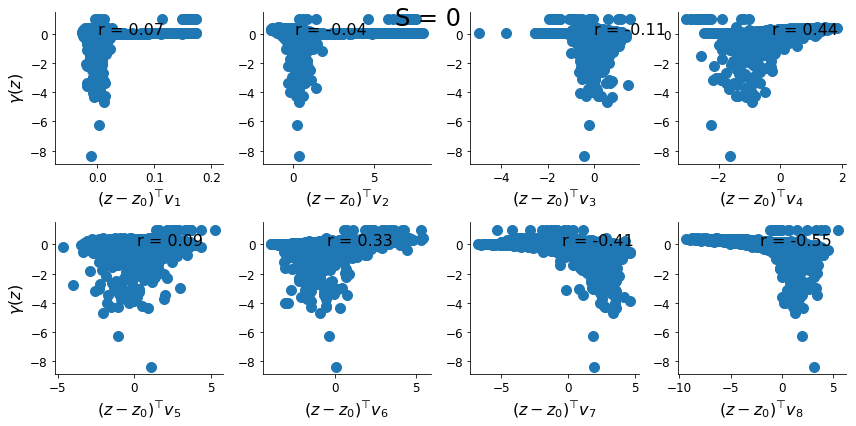

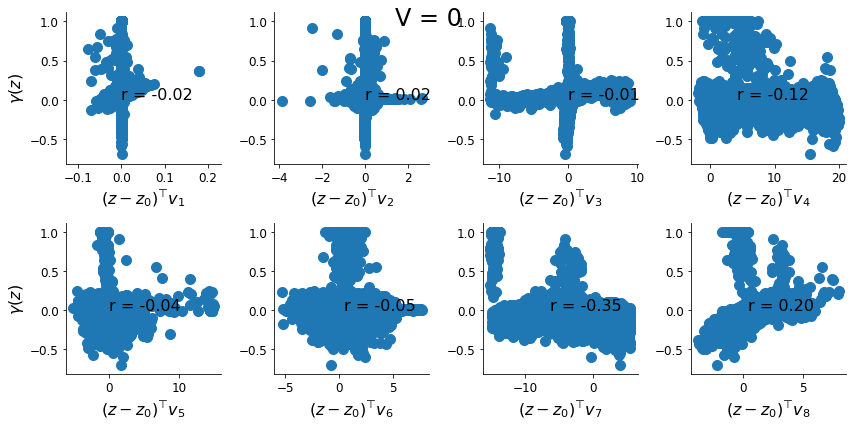

In [22]:
%matplotlib inline
valid_inds_list = []
for k in range(2):
    silenced = silenced_pops[k]
    system = systems[k]
    
    D = Ds[k]
    V = Vs[k]
    w_max = w_maxes[k]
    z_max = z_maxes[k]
    
    lim1 = lim1s[k]
    lim2 = lim2s[k]
    
    _Z = Zs[k][0]
    _T_x = T_xs[k][0]
    
    y = _T_x[:,0]
    valid_inds = y > -100
    valid_inds_list.append(valid_inds)
    _Z = _Z[valid_inds,:]
    
    _Z_pert = _Z - np.expand_dims(z_max, 0)
    y = y[valid_inds]
    y_mean = np.mean(y)
    fig, axs = plt.subplots(2,4,figsize=(12,6))
    for i in range(2):
        for j in range(4):
            ind = 4*i+j
            v = V[:,ind]
            _Zv = np.dot(_Z_pert, v)
            r = np.corrcoef(_Zv, y)
            axs[i][j].scatter(_Zv, y)
            proj_mean = np.mean(_Zv)
            axs[i][j].text(proj_mean - (0.33)*np.abs(proj_mean), y_mean + 0.33*(np.abs(y_mean)), 'r = %.2f' % r[0,1], fontsize=16)
            axs[i][j].set_xlabel(r'$(z-z_0)^\top v_%d$' % (ind+1))
        axs[i,0].set_ylabel(r'$\gamma(z)$')
    plt.tight_layout()
    plt.suptitle("%s = 0" % silenced, fontsize=24)
    plt.show()


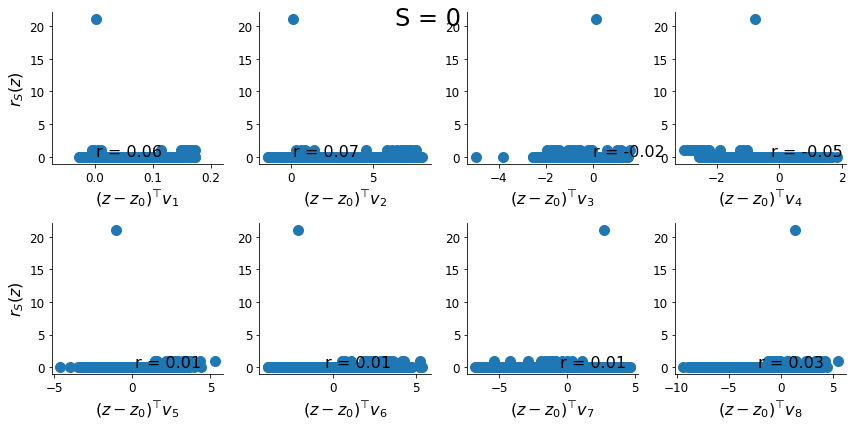

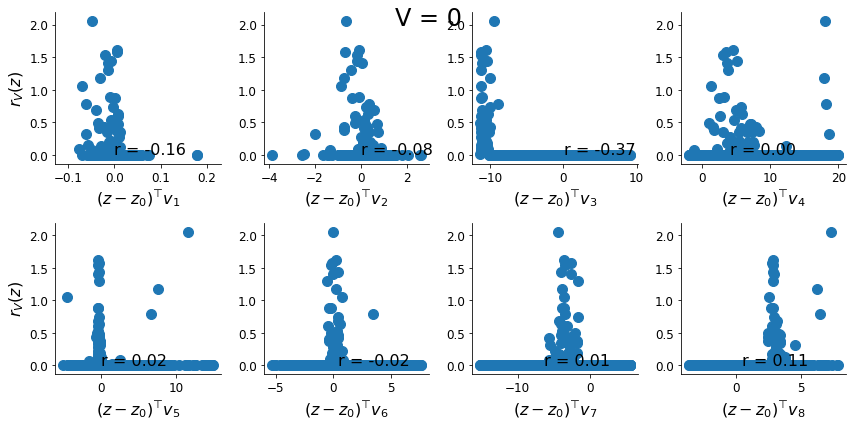

In [24]:
%matplotlib inline
for k in range(2):
    silenced = silenced_pops[k]
    system = systems[k]
    
    D = Ds[k]
    V = Vs[k]
    w_max = w_maxes[k]
    z_max = z_maxes[k]
    
    lim1 = lim1s[k]
    lim2 = lim2s[k]
    
    _Z = Zs[k][0]
    _T_x = T_xs[k][0]
    
    valid_inds = valid_inds_list[k]
    _Z = _Z[valid_inds,:]
    
    _Z_pert = _Z - np.expand_dims(z_max, 0)
    y = _T_x[valid_inds,2]
    y_mean = np.mean(y)
    fig, axs = plt.subplots(2,4,figsize=(12,6))
    for i in range(2):
        for j in range(4):
            ind = 4*i+j
            v = V[:,ind]
            _Zv = np.dot(_Z_pert, v)
            r = np.corrcoef(_Zv, y)
            axs[i][j].scatter(_Zv, y)
            proj_mean = np.mean(_Zv)
            axs[i][j].text(proj_mean - (0.33)*np.abs(proj_mean), y_mean + 0.33*(np.abs(y_mean)), 'r = %.2f' % r[0,1], fontsize=16)
            axs[i][j].set_xlabel(r'$(z-z_0)^\top v_%d$' % (ind+1))
        axs[i,0].set_ylabel(r'$r_%s(z)$' % silenced)
    plt.tight_layout()
    plt.suptitle("%s = 0" % silenced, fontsize=24)
    plt.show()
